## Checking basic derivation

Define a basic function and check changes by incrementing tiny values

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def samplefunction(x):
    return 4*x**2 + 4*x + 4

samplefunction(1)

12

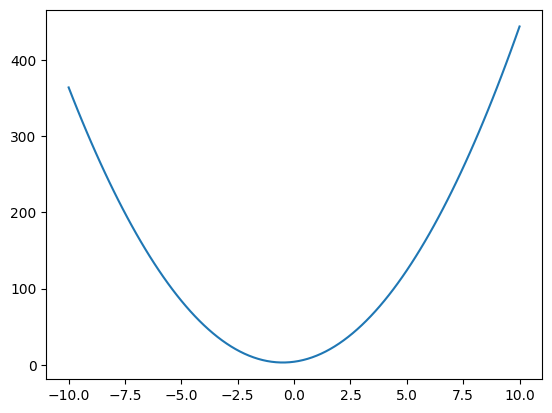

In [3]:
x_points = np.arange(-10, 10.2, 0.2)
y_points = samplefunction(x_points)
plt.plot(x_points, y_points)

In [4]:
x = 0.5

# d(samplefunction(x))/dx = 8*x + 4
# when x = 0.5 => 8*0.5 + 4 = 8

h1 = 0.00001
h2 = 0.000000001
print(f"Value of derivative when incremented by 0.00001: {(samplefunction(x+h1) - samplefunction(x))/h1}")
print(f"Value of derivative when incremented by 0.000000001: {(samplefunction(x+h2) - samplefunction(x))/h2}")

Value of derivative when incremented by 0.00001: 8.000039999966901
Value of derivative when incremented by 0.000000001: 7.999999773744547


## Define graphviz

A library to plot graphs, here it will help us to plot the network

In [5]:
from graphviz import Digraph

#construct nodes and edges
def construct(node, nodes, edges):
    if node not in nodes:
        nodes.add(node)
        for child in node.previous:
            edges.add((child, node))
            construct(child, nodes, edges)

#calls construct for the first time
def dfs(root):
    nodes = set()
    edges = set()
    construct(root, nodes, edges)
    return nodes, edges

#constructs the graph
def graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = dfs(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.name, n.value, n.grad), shape='record')
        if n.operator:
          dot.node(name = uid + n.operator, label = n.operator)
          dot.edge(uid + n.operator, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

## Define class for each variable

This is a wrapper around each variable which helps us to do various operations on it based on our definitions

In [6]:
class Variable:

    def __init__(self, value, relation=(), operator='', name=''):
        self.value = value
        self.grad = 0.0
        self.previous = set(relation)
        self.operator = operator
        self.name = name
        self.back = lambda: None        # define an empty function for now

    def __repr__(self):
        if(self.name != ''):
            return f"Variable(value={self.value}, name='{self.name}')"
        return f"Variable(value={self.value})"

    def __add__(self, next):
        next = next if isinstance(next, Variable) else Variable(next)
        out = Variable(self.value + next.value, (self, next), '+')

        def back():
            self.grad += 1.0 * out.grad
            next.grad += 1.0 * out.grad
        out.back = back
        return out

    def __sub__(self, next):
        return self + (-next)

    def __neg__(self, next):
        return self * -1

    def __radd__(self, next):
        return self + next

    def __truediv__(self, next):
        return self * next**-1

    def __pow__(self, next):
        output = Variable(self.value ** next, (self, ), f'**{next}')

        def back():
            self.grad = next * (self.value ** (next - 1)) * output.grad
        output.back = back

        return output

    def __mul__(self, next):
        next = next if isinstance(next, Variable) else Variable(next)
        out = Variable(self.value * next.value, (self, next), '*')

        def back():
            self.grad += next.value * out.grad
            next.grad += self.value * out.grad
        out.back = back
        
        return out

    def sigmoid(self):
        z = self.value
        temp = (1/(1+math.exp(-1*z)))
        output = Variable(temp, (self, ), 'sig')

        def back():
            self.grad += temp * (1 - temp) * output.grad
        output.back = back
        
        return output

    def backward(self):
        list_in_order = []
        visited = set()
        def topological_sort(node):
            if node not in visited:
                visited.add(node)
                for temp in node.previous:
                    topological_sort(temp)
                list_in_order.append(node)
        
        topological_sort(self)

        self.grad = 1.0
        list_in_order.reverse()
        for node in list_in_order:
            node.back()


## Behaviour of each neuron

A basic check for each neuron with 2 variables, 2 weights for the variables and a bias for the neuron
The function implemented is the sigmoid function

In [7]:
# inputs x1,x2
x1 = Variable(1.0, name='x1')
x2 = Variable(0.0, name='x2')

# weights w1,w2
w1 = Variable(-2.0, name='w1')
w2 = Variable(2.0, name='w2')

# bias of the neuron
b = Variable(3, name='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.name = 'x1*w1'
x2w2 = x2*w2; x2w2.name = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.name = 'n'
o = n.sigmoid(); o.name = 'o'

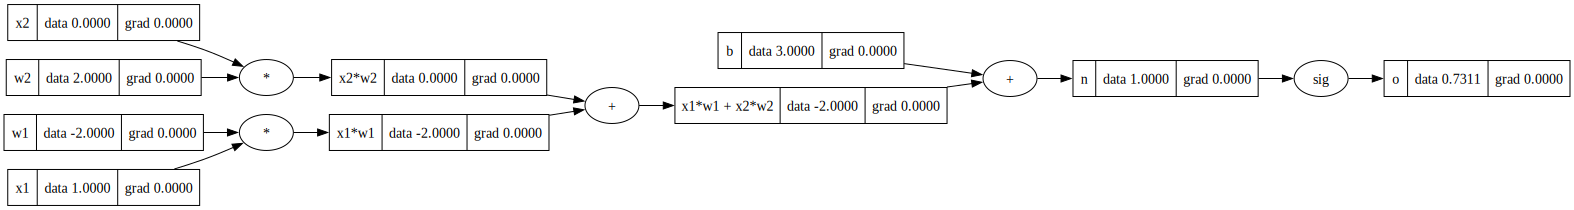

In [8]:
graph(o)

In [9]:
# In order to call back function in order such that the last value is called first then later values we use
# topological sort

o.grad = 1.0

list_in_order = []
visited = set()
def topological_sort(node):
    if node not in visited:
        visited.add(node)
        for temp in node.previous:
            topological_sort(temp)
        list_in_order.append(node)

topological_sort(o)

list_in_order.reverse()

for node in list_in_order:
    node.back()



## Put this function in the variable class as a backward function so that this code is not there openly lying around

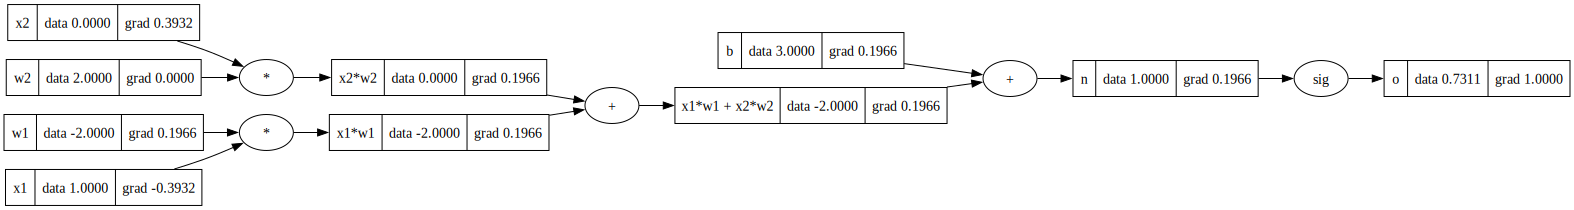

In [10]:
graph(o)

In [11]:
# After defining backward function with the above cell implementation
o.backward()

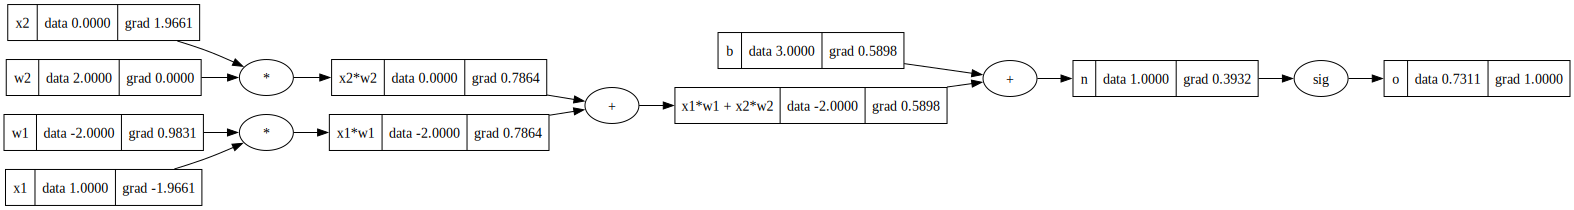

In [12]:
graph(o)

## Define a class Neuron, Layer and Network
This is to construct the entire neural network with random weights and randon biases to start with

In [13]:
class Neuron:

    def __init__(self, number_of_inputs):
        self.weight = [Variable(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.bias = Variable(random.uniform(-1, 1))

    def __call__(self, input):
        # a = summation (wi*xi) + b
        
        # weighted_input = (inputi*weighti for inputi, weighti in zip(input, self.weight))
        activation = sum((weighti*inputi for inputi, weighti in zip(input, self.weight)), self.bias)
        output = activation.sigmoid()
        return output

    def definition(self):
        return self.weight + [self.bias]

class Layer:

    def __init__(self, number_of_input, number_of_output):
        self.neurons = [Neuron(number_of_input) for _ in range(number_of_output)]

    def __call__(self, input):
        output = [temp(input) for temp in self.neurons]
        if(len(output) == 1):
            return output[0]
        return output

    def definition(self):
        return [temp for neuron in self.neurons for temp in neuron.definition()]

class Network:

    def __init__(self, number_of_inputs, number_of_outputs):
        temp = [number_of_inputs] + number_of_outputs
        self.layers = [Layer(temp[i], temp[i+1]) for i in range(len(number_of_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def definition(self):
        return [temp for layer in self.layers for temp in layer.definition()]

In [14]:
## neural network
#                              neuron
# (-1.0, 3.0, 4.0)--> neuron   neuron   neuron
# (-1.0, 3.0, 4.0)--> neuron   neuron   neuron   neuron
# (-1.0, 3.0, 4.0)--> neuron   neuron   neuron
#                              neuron

x = [-1.0, 3.0, 4.0]
n = Network(3, [5, 3, 1])
n(x)

Variable(value=0.7192477401330745)

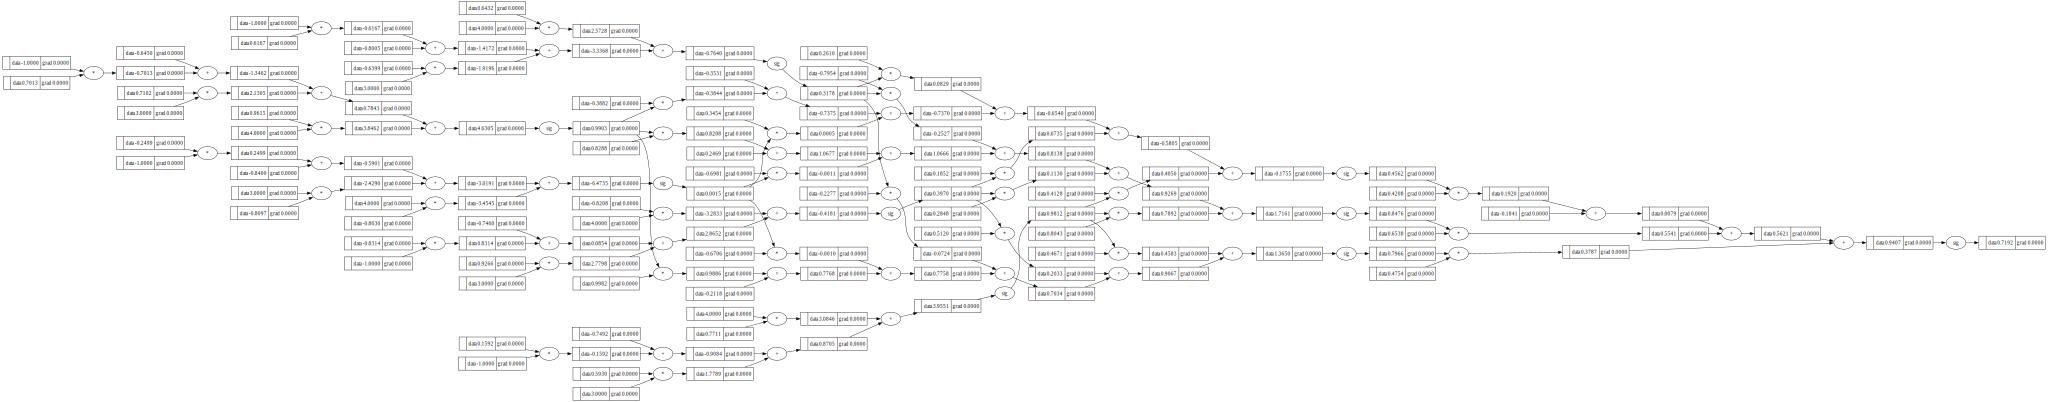

In [15]:
graph(n(x))

In [89]:
## XOR classifier
net = Network(2, [4, 1])

In [90]:
xs = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
]

ys = [0.0, 1.0, 1.0, 0.0]

In [97]:
for iteration in range(20):

    # forward pass
    y_predictions = [net(temp) for temp in xs]
    loss = sum((y_prediction - y_desired)**2 for y_desired, y_prediction in zip(ys, y_predictions)) / (2*len(xs))
    
    #backward pass
    for temp in net.definition():
        temp.grad = 0.0
    loss.backward()

    #update
    for temp in net.definition():
        temp.value += -2.0 * temp.grad

    print(f"Iteration number {iteration}: {loss.value}")

Iteration number 0: 0.12374297835500248
Iteration number 1: 0.12370630824564269
Iteration number 2: 0.12366952377249504
Iteration number 3: 0.12363261563311859
Iteration number 4: 0.1235955745310367
Iteration number 5: 0.1235583911720608
Iteration number 6: 0.12352105626064012
Iteration number 7: 0.1234835604962349
Iteration number 8: 0.12344589456971294
Iteration number 9: 0.12340804915976777
Iteration number 10: 0.1233700149293568
Iteration number 11: 0.12333178252215962
Iteration number 12: 0.12329334255905344
Iteration number 13: 0.12325468563460637
Iteration number 14: 0.12321580231358577
Iteration number 15: 0.12317668312748162
Iteration number 16: 0.12313731857104324
Iteration number 17: 0.12309769909882895
Iteration number 18: 0.12305781512176636
Iteration number 19: 0.12301765700372366


In [98]:
y_predictions

[Variable(value=0.5164394682778766),
 Variable(value=0.4690651642540737),
 Variable(value=0.5418713715674234),
 Variable(value=0.4750346215136174)]